# Harmonizing data located within and outside of the NASA Earthdata Cloud

---

## Timing

- Exercise: 45 min
-
-


---

## Summary

This tutorial will combine several workflow steps and components from the previous days, demonstrating the process of using the geolocation of data available outside of the Earthdata Cloud to then access coincident variables of cloud-accessible data. This may be a common use case as NASA Earthdata continues to migrate to the cloud, producing a "hybrid" data archive across Amazon Web Services (AWS) and original on-premise data storage systems. Additionally, you may also want to combine field measurements with remote sensing data available on the Earthdata Cloud.

This specific example explores the harmonization of the ICESat-2 ATL03 data product, currently (as of November 2021) available publicaly via direct download at the NSIDC DAAC, with Sea Surface Temperature variables available from PO.DAAC on the Earthdata Cloud. 


### Objectives




---

### Import packages

In [46]:
pip install icepyx

     |████████████████████████████████| 46 kB 621 kB/s             
     |████████████████████████████████| 1.0 MB 12.6 MB/s            
  Using cached xarray-0.19.0-py3-none-any.whl (827 kB)
     |████████████████████████████████| 4.3 MB 50.5 MB/s            
     |████████████████████████████████| 15.8 MB 26.1 MB/s            
     |████████████████████████████████| 3.1 MB 61.9 MB/s            
     |████████████████████████████████| 4.5 MB 91.8 MB/s            
     |████████████████████████████████| 15.7 MB 77.4 MB/s            
     |████████████████████████████████| 1.1 MB 34.4 MB/s            
     |████████████████████████████████| 15.4 MB 51.0 MB/s            
  Using cached intake-0.6.4-py3-none-any.whl (1.5 MB)
     |████████████████████████████████| 10.3 MB 72.9 MB/s            
     |████████████████████████████████| 76 kB 751 kB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 85 kB 616 kB/s             
     |███████████████

In [49]:
# import getpass
# from requests.auth import HTTPBasicAuth

import requests
from pprint import pprint
import os
from xml.etree import ElementTree as ET
import time
import zipfile
import io
import shutil
import json
import icepyx as ipx

### Determine storage location of datasets of interest

First, let's see whether our datasets of interest reside in the Earthdata Cloud or whether they reside on premise, or "on prem" at a local data center.

Background from CMR API (consider removing):
The cloud_hosted parameter can be set to “true” or “false”. When true, the results will be restricted to collections that have a DirectDistributionInformation element or have been tagged with gov.nasa.earthdatacloud.s3.
curl “https://cmr.earthdata.nasa.gov/search/collections?cloud_hosted=true”

### Declare datasets of interest

Identify the dataset ID that is used internally within CMR to designate each dataset

In [20]:
sentinel_name = 'SENTINEL-1A_DP_META_GRD_MEDIUM'
# sentinel_id = 'C1214472336-ASF'

icesat2_name = 'ATL03'
# icesat2_id = 'C1997321091-NSIDC_ECS'

In [37]:
CMR_OPS = 'https://cmr.earthdata.nasa.gov/search'
url = f'{CMR_OPS}/{"collections"}'

response = requests.get(url, 
                        params={
                            'short_name': sentinel_name,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
collections = response.json()['feed']['entry']
# collection_id = collections[0]['id']  
# print(collection_id)

for collection in collections:
    print(f'{collection["id"]} {"version:"}{collection["version_id"]}')

C1214472336-ASF version:1


Start with the Sentinel dataset, setting the `cloud_hosted` parameter to True:

In [24]:
# CMR_OPS = 'https://cmr.earthdata.nasa.gov/search'
# url = f'{CMR_OPS}/{"collections"}'

response = requests.get(url, 
                        params={
                            'concept_id': 'C1214472336-ASF',
                            'cloud_hosted': 'True',
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
collections = response.json()['feed']['entry']
pprint(collections)

[{'archive_center': 'ASF',
  'boxes': ['-90 -180 90 180'],
  'browse_flag': False,
  'coordinate_system': 'CARTESIAN',
  'data_center': 'ASF',
  'dataset_id': 'SENTINEL-1A_DUAL_POL_METADATA_GRD_MEDIUM_RES',
  'has_formats': False,
  'has_spatial_subsetting': False,
  'has_temporal_subsetting': False,
  'has_transforms': False,
  'has_variables': False,
  'id': 'C1214472336-ASF',
  'links': [{'href': 'https://vertex.daac.asf.alaska.edu/',
             'hreflang': 'en-US',
             'rel': 'http://esipfed.org/ns/fedsearch/1.1/data#'}],
  'online_access_flag': True,
  'orbit_parameters': {},
  'organizations': ['ASF'],
  'original_format': 'ECHO10',
  'platforms': ['Sentinel-1A'],
  'service_features': {'esi': {'has_formats': False,
                               'has_spatial_subsetting': False,
                               'has_temporal_subsetting': False,
                               'has_transforms': False,
                               'has_variables': False},
                

Now we will try our ICESat-2 dataset to see what id's are returned for a given dataset name.

In [38]:
response = requests.get(url, 
                        params={
                            'short_name': icesat2_name,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
collections = response.json()['feed']['entry']
# pprint(collections)

for collection in collections:
    print(f'{collection["id"]} {"version:"}{collection["version_id"]}')

C1705401930-NSIDC_ECS version:003
C1997321091-NSIDC_ECS version:004


Two separate datasets exist in the CMR. Now let's take each ID, setting the `cloud_hosted` parameter to True, to identify which dataset is cloud-hosted:

In [40]:
CMR_OPS = 'https://cmr.earthdata.nasa.gov/search'
url = f'{CMR_OPS}/{"collections"}'

response = requests.get(url, 
                        params={
                            'concept_id': 'C1997321091-NSIDC_ECS',
                            # 'cloud_hosted': 'True',
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
collections = response.json()['feed']['entry']
pprint(collections)

[{'archive_center': 'NASA NSIDC DAAC',
  'associations': {'services': ['S1568899363-NSIDC_ECS',
                                'S1613689509-NSIDC_ECS',
                                'S1977894169-NSIDC_ECS',
                                'S2013502342-NSIDC_ECS'],
                   'tools': ['TL1950215144-NSIDC_ECS',
                             'TL1977971361-NSIDC_ECS',
                             'TL1993837300-NSIDC_ECS',
                             'TL1952642907-NSIDC_ECS']},
  'boxes': ['-90 -180 90 180'],
  'browse_flag': False,
  'coordinate_system': 'CARTESIAN',
  'data_center': 'NSIDC_ECS',
  'dataset_id': 'ATLAS/ICESat-2 L2A Global Geolocated Photon Data V004',
  'has_formats': True,
  'has_spatial_subsetting': True,
  'has_temporal_subsetting': True,
  'has_transforms': False,
  'has_variables': True,
  'id': 'C1997321091-NSIDC_ECS',
  'links': [{'href': 'https://n5eil01u.ecs.nsidc.org/ATLAS/ATL03.004/',
             'hreflang': 'en-US',
             'length': '0.0KB',


What happens if we comment out this parameter? Do we see results returned? 
[TODO: Add instructions on how to comment lines using command slash]

Now we have determined that our Sentinel dataset is provided in the cloud, whereas the ICESat-2 dataset remains "on premise", residing in a local data center. 

### Determine size of ATL03 data over area of interest 
(determine large size; need to subset by geographic region)

#### Determine time and area of interest 

These `bounding_box` and `temporal` variables will be used for data search, subset, and access below

(Quick demo of OpenAltimetry or Earthdata Search for exploration of ICESat-2 or both datasets??)

In [41]:
# Bounding Box spatial parameter in decimal degree 'W,S,E,N' format. TODO: Show on a simple map??
bounding_box = '-31.68073,61.21566,-12.15967,83.56771'

# Each date in yyyy-MM-ddTHH:mm:ssZ format; date range in start,end format
temporal = '2021-01-01T00:00:00Z,2021-01-31T23:59:59Z'

In [ ]:
# Determine size and number of granules

# TODO: Need to pair down bounding box/time; we get 186 granules back in EDSC

### Determine subsetting capabilities of ATL03

Consider removing since we see basic service info in the colleciton-level tags (has_spatial_subsetting, etc.)

In [43]:
# CMR_OPS = 'https://cmr.earthdata.nasa.gov/search'
# url = f'{CMR_OPS}/{"collections"}'

response = requests.get(url, 
                        params={
                            'concept_id': 'C1997321091-NSIDC_ECS',
#                            'cloud_hosted': 'True',
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
response = response.json()
services = response['feed']['entry'][0]['associations']['services']
output_format = "umm_json"
service_url = "https://cmr.earthdata.nasa.gov/search/services"
for i in range(len(services)):
    response = requests.get(f"{service_url}.{output_format}?concept-id={services[i]}")
    response = response.json()
    if 'ServiceOptions' in response['items'][0]['umm']: pprint(response['items'][0]['umm']['ServiceOptions'])

{'Subset': {'SpatialSubset': {'BoundingBox': {'AllowMultipleValues': False},
                              'Circle': {'AllowMultipleValues': False},
                              'Point': {'AllowMultipleValues': False},
                              'Polygon': {'AllowMultipleValues': False},
                              'Shapefile': [{'Format': 'ESRI'},
                                            {'Format': 'GeoJSON'},
                                            {'Format': 'KML'}]},
            'TemporalSubset': {'AllowMultipleValues': False},
            'VariableSubset': {'AllowMultipleValues': False}},
 'SupportedReformattings': [{'SupportedInputFormat': 'HDF5',
                             'SupportedOutputFormats': ['ASCII',
                                                        'HDF5',
                                                        'NETCDF-3',
                                                        'NETCDF-4']}]}


### Subset and download ATL03 

(Describe that this is being "downloaded" to our cloud environment - what does that mean in terms of cost, etc.)

Using Icepyx...

In [65]:
# # Each date in yyyy-MM-ddTHH:mm:ssZ format; date range in start,end format
# temporal = '2021-01-01T00:00:00Z,2021-01-31T23:59:59Z'

#icepyx params

#convert bounding_box which is a string, to a list of floats

to_list = bounding_box.split(",")
print(to_list)
spatial_list = [float(x) for x in string_list]
print(spatial_list)

# New date range since icepyx provides dates as YYYY-MM-DD

date_range = ['2021-01-01','2021-01-31']

region_a = ipx.Query(icesat2_name, spatial_list, date_range)

['-31.68073', '61.21566', '-12.15967', '83.56771']
[-31.68073, 61.21566, -12.15967, 83.56771]


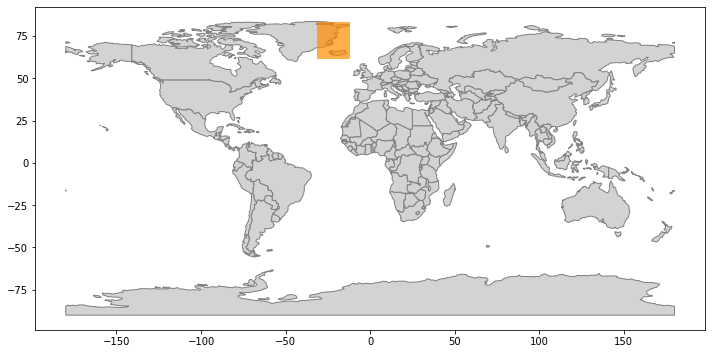

In [66]:
region_a.visualize_spatial_extent()

In [ ]:
#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'

# bounding box search and subset:
param_dict = {'short_name': 'ATL03', 
              'version': '004', 
              'temporal': temporal, 
              'bounding_box': bounding_box, 
              'bbox': bounding_box, 
              'coverage': '/gt1r/heights/h_ph,/gt1l/heights/h_ph,/gt2r/heights/h_ph,/gt2l/heights/h_ph,/gt1r/heights/lat_ph,/gt1l/heights/lat_ph,/gt2r/heights/lat_ph,/gt2l/heights/lat_ph,/gt1r/heights/lon_ph,/gt1l/heights/lon_ph,/gt2r/heights/lon_ph,/gt2l/heights/lon_ph',
              'page_size': '10', 
              'request_mode': 'async',
#              'token' : _token,
             }

#Remove blank key-value-pairs
param_dict = {k: v for k, v in param_dict.items() if v != ''}

#Convert to string
param_string = '&'.join("{!s}={!r}".format(k,v) for (k,v) in param_dict.items())
param_string = param_string.replace("'","")

API_request = api_request = f'{base_url}?{param_string}'
print(API_request)

In [ ]:
#TODO: Need to make code much simpler!!

# Create an output folder if the folder does not already exist.

path = str(os.getcwd() + '/Outputs')
if not os.path.exists(path):
    os.mkdir(path)

# For all requests other than spatial file upload, use get function
session = requests.session()
request = session.get(base_url, params=param_dict)

print('Request HTTP response: ', request.status_code)

# Raise bad request: Loop will stop for bad response code.
request.raise_for_status()
print('Order request URL: ', request.url)
esir_root = ET.fromstring(request.content)
print('Order request response XML content: ', request.content)

#Look up order ID
orderlist = []   
for order in esir_root.findall("./order/"):
    orderlist.append(order.text)
orderID = orderlist[0]
print('order ID: ', orderID)

#Create status URL
statusURL = base_url + '/' + orderID
print('status URL: ', statusURL)

#Find order status
request_response = session.get(statusURL)    
print('HTTP response from order response URL: ', request_response.status_code)

# Raise bad request: Loop will stop for bad response code.
request_response.raise_for_status()
request_root = ET.fromstring(request_response.content)
statuslist = []
for status in request_root.findall("./requestStatus/"):
    statuslist.append(status.text)
status = statuslist[0]
print('Data request is submitting...')
print('Initial request status is ', status)

#Continue loop while request is still processing
while status == 'pending' or status == 'processing': 
    print('Status is not complete. Trying again.')
    time.sleep(10)
    loop_response = session.get(statusURL)

# Raise bad request: Loop will stop for bad response code.
    loop_response.raise_for_status()
    loop_root = ET.fromstring(loop_response.content)

#find status
    statuslist = []
    for status in loop_root.findall("./requestStatus/"):
        statuslist.append(status.text)
    status = statuslist[0]
    print('Retry request status is: ', status)
    if status == 'pending' or status == 'processing':
        continue

#Order can either complete, complete_with_errors, or fail:
# Provide complete_with_errors error message:
if status == 'complete_with_errors' or status == 'failed':
    messagelist = []
    for message in loop_root.findall("./processInfo/"):
        messagelist.append(message.text)
    print('error messages:')
    pprint.pprint(messagelist)

# Download zipped order if status is complete or complete_with_errors
if status == 'complete' or status == 'complete_with_errors':
    downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
    print('Zip download URL: ', downloadURL)
    print('Beginning download of zipped output...')
    zip_response = session.get(downloadURL)
    # Raise bad request: Loop will stop for bad response code.
    zip_response.raise_for_status()
    with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
        z.extractall(path)
    print('Data request is complete.')
else: print('Request failed.')

#### Clean up Outputs folder by removing individual granule folders 

In [ ]:
for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
    for name in dirs:
        os.rmdir(os.path.join(root, name))

### Determine size of SAR data

In [ ]:
CMR_OPS = 'https://cmr.earthdata.nasa.gov/search'
url = f'{CMR_OPS}/{"granules"}'

response = requests.get(url, 
                        params={
                            'concept_id': 'C1214472336-ASF',
#                             'concept_id': 'C1997321091-NSIDC_ECS',
                            'bounding_box': bounding_box,
                            'temporal': temporal,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
granules = response.json()['feed']['entry']
#pprint(granules)

results = json.loads(response.content)
granules = []
granules.extend(results['feed']['entry'])
hits = int(response.headers['CMR-Hits'])
print(f"Found {hits} files")
granule_sizes = [float(granule['granule_size']) for granule in granules]
print(f"The total size of all files is {sum(granule_sizes):.2f} MB")

### Determine variables of interest: SST, ocean color, chemistry...

Is this now no longer needed since it's just a single variable??

### Pull those variables into xarray "in place"

### Use geolocation of ICESat-2 to define the single transect used to pull coincident ocean data out from array

### Create a plot of the single transect of gridded data 

(bonus: time series) - describe what this means to egress out of the cloud versus pulling the original data down (benefit to processing in the cloud)

## Exercise

In [ ]:
# maybe an exercise that builds off of previous tutorials? Discover services or storage in CMR?

---

## Resources (optional)

---

## Conclusion